<a href="https://colab.research.google.com/github/wulanasyifaa/Analysis-of-Linear-Regression-Random-Forest-and-Gradient-Boosting-Variants-for-Parkinson-Dataset/blob/main/Analysis_of_Linear_Regression%2C_Random_Forest%2C_and_Gradient_Boosting_Variants_for_Parkinson_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wulan Asyifa

Data Source: https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

## **Import Library**


Berikut adalah beberapa pustaka (library) utama yang digunakan:
* *pandas, numpy* → Untuk manipulasi data dan perhitungan numerik.
* *seaborn, matplotlib.pyplot* → Untuk visualisasi data dan hasil prediksi model.
* *xgboost, catboost, GradientBoostingRegressor* → Untuk model berbasis boosting.
* *LinearRegression* → Untuk model regresi linear sebagai baseline.
* *train_test_split, StandardScaler* → Untuk membagi dataset dan melakukan normalisasi fitur.
* *mean_absolute_error, mean_squared_error, r2_score* → Untuk mengevaluasi performa model.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from math import sqrt
from scipy.stats import zscore
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import HTML

# **Load Data**

In [ ]:
file_path = "/content/parkinsons_updrs.csv"
df = pd.read_csv(file_path)

In [ ]:
df.head()

,subject,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


Dataset *Parkinson Telemonitoring* dari UC Irvine Machine Learning Repository berisi pengukuran suara biomedis dari 42 pasien Parkinson tahap awal yang mengikuti uji coba telemonitoring selama enam bulan, dengan rekaman suara yang dikumpulkan otomatis di rumah pasien. Tabel mencakup nomor subjek, usia, jenis kelamin, waktu sejak perekrutan, skor motor dan total UPDRS, serta 16 pengukuran suara, dengan total 5.875 rekaman. Tujuan utama dataset ini adalah memprediksi skor **motor_UPDRS** dan **total_UPDRS** berdasarkan 16 fitur suara.

---

**Deskripsi Variabel**


Variabel Independen (X):

- **subject** – Angka unik yang mengidentifikasi setiap subjek penelitian.  
- **age** – Usia subjek.  
- **sex** – Jenis kelamin subjek, dengan '0' untuk laki-laki dan '1' untuk perempuan.  
- **test_time** – Waktu sejak subjek direkrut ke dalam uji coba. Bagian bilangan bulat menunjukkan jumlah hari sejak perekrutan.    
- **motor_UPDRS** – Skor UPDRS motorik yang diberikan oleh klinisi, diperoleh melalui interpolasi linier.
- **Jitter(%)**, **Jitter(Abs)**, **Jitter:RAP**, **Jitter:PPQ5**, **Jitter:DDP** – Berbagai ukuran variasi dalam frekuensi fundamental suara, yang mencerminkan ketidakstabilan suara.  
- **Shimmer**, **Shimmer(dB)**, **Shimmer:APQ3**, **Shimmer:APQ5**, **Shimmer:APQ11**, **Shimmer:DDA** – Berbagai ukuran variasi dalam amplitudo suara, yang menunjukkan fluktuasi dalam intensitas suara.  
- **NHR**, **HNR** – Dua ukuran rasio antara komponen noise dan komponen tonal dalam suara. NHR (Noise-to-Harmonics Ratio) menunjukkan seberapa besar noise dalam suara, sedangkan HNR (Harmonics-to-Noise Ratio) menunjukkan seberapa dominan komponen harmonik dibandingkan noise.  
- **RPDE** – Ukuran kompleksitas dinamika nonlinier dalam suara, yang digunakan untuk menganalisis pola perubahan suara.  
- **DFA** – Eksponen penskalaan fraktal dari sinyal suara, yang mengukur kestabilan pola suara dalam jangka panjang.  
- **PPE** – Ukuran nonlinier dari variasi frekuensi fundamental, yang menunjukkan seberapa besar perubahan nada suara dari waktu ke waktu.  

Variabel Dependenden (Y):

- **Total_UPDRS (Y1)** – Skor UPDRS total (mencakup semua aspek) yang diberikan oleh klinisi, diperoleh melalui interpolasi linier.  
- **Motor_UPDRS (Y2)** –Skor UPDRS untuk aspek motorik pasien yang diberikan oleh klinisi, diperoleh melalui interpolasi linier.

---

 Target yang digunakan:

*   **Regresi** → Total_UPDRS sebagai variabel kontinu.

Data kemudian dibagi menjadi **train** dan **test (80:20)** dan dinormalisasi menggunakan *StandardScaler* untuk meningkatkan performa model.



# **Exploratory Data Analysis**

## Cek Tipe Data

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject        5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

**Jumlah Data:**

Dataset terdiri dari 5.875 baris (entries) dan 22 kolom (features).

**Tipe Data:**

Terdapat 3 kolom bertipe integer (int), yaitu subject, age, dan sex. Kolom ini berisi data numerik atau kategorik.

Terdapat 19 kolom bertipe kontinu (float), yang mencakup variabel terkait pengukuran jitter, shimmer, dan parameter lainnya.



## Drop Variabel yang tidak diperlukan

In [ ]:
df = df.drop(columns=['subject', 'test_time'])

## Cek Distribusi Data

In [ ]:
print(df.describe())

               age          sex  motor_UPDRS  total_UPDRS    Jitter(%)  \
count  5875.000000  5875.000000  5875.000000  5875.000000  5875.000000   
mean     64.804936     0.317787    21.296229    29.018942     0.006154   
std       8.821524     0.465656     8.129282    10.700283     0.005624   
min      36.000000     0.000000     5.037700     7.000000     0.000830   
25%      58.000000     0.000000    15.000000    21.371000     0.003580   
50%      65.000000     0.000000    20.871000    27.576000     0.004900   
75%      72.000000     1.000000    27.596500    36.399000     0.006800   
max      85.000000     1.000000    39.511000    54.992000     0.099990   

       Jitter(Abs)   Jitter:RAP  Jitter:PPQ5   Jitter:DDP      Shimmer  \
count  5875.000000  5875.000000  5875.000000  5875.000000  5875.000000   
mean      0.000044     0.002987     0.003277     0.008962     0.034035   
std       0.000036     0.003124     0.003732     0.009371     0.025835   
min       0.000002     0.000330     0

## Cek Data Duplikat

In [ ]:
# Cek jumlah data yang duplikat
num_duplicates = df.duplicated().sum()
print(f"Jumlah data duplikat: {num_duplicates}")

# Jika ingin melihat baris mana saja yang duplikat
df_duplikat = df[df.duplicated()]
print("Data duplikat:")
display(df_duplikat)


Jumlah data duplikat: 0
Data duplikat:


,age,sex,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE


Berdasarkan hasil pengecekan, tidak ditemukan adanya data yang duplikat dalam dataset ini, dengan jumlah duplikasi sebesar 0. Hal ini menunjukkan bahwa setiap baris data sudah bersih dan tidak ada pengulangan entri.

## Cek Missing Value

In [ ]:
df.isnull().sum()

,0
age,0
sex,0
motor_UPDRS,0
total_UPDRS,0
Jitter(%),0
Jitter(Abs),0
Jitter:RAP,0
Jitter:PPQ5,0
Jitter:DDP,0
Shimmer,0


semua variabel menghasilkan angka 0 sehingga tidak terdapat missing value pada dataset ini

## Cek Multikolinearitas

In [ ]:
# Hitung VIF untuk tiap variabel, kecuali 'sex'
X = df.drop(columns=["motor_UPDRS", "total_UPDRS", "sex"])  # Kecualikan 'sex' karena merupakan data kategorik
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_sorted = vif.sort_values(by="VIF", ascending=True)

# Tampilkan hasil
vif_sorted

,Variable,VIF
12,NHR,9.631153e+00
2,Jitter(Abs),1.644690e+01
16,PPE,2.845776e+01
14,RPDE,4.375325e+01
10,Shimmer:APQ11,4.403994e+01
0,age,5.131144e+01
13,HNR,5.166420e+01
4,Jitter:PPQ5,5.410027e+01
15,DFA,9.080552e+01
9,Shimmer:APQ5,1.292079e+02


Berdasarkan nilai Variance Inflation Factor (VIF) yang ditampilkan, dapat disimpulkan bahwa terdapat multikolinearitas yang cukup signifikan dalam dataset ini.

**Variabel dengan VIF rendah hingga sedang (<10):**

NHR (9,63) memiliki nilai VIF yang masih dalam batas aman, menunjukkan bahwa tidak ada masalah serius dengan multikolinearitas untuk variabel ini.

**Variabel dengan VIF tinggi (>10 dan <100):**

Variabel seperti Jitter(Abs) (16,44), PPE (28,46), RPDE (43,75), Shimmer:APQ11 (44,04), Age (51,31), HNR (51,66), Jitter:PPQ5 (54,10) , dan DFA (90,80) menunjukkan adanya tingkat multikolinearitas yang cukup tinggi.
Variabel shimmer dan jitter lainnya juga memiliki nilai VIF yang cukup besar (ratusan), menunjukkan bahwa beberapa di antaranya mungkin berkorelasi erat satu sama lain.

**Variabel dengan VIF sangat tinggi (>1000):**

Variabel seperti Jitter:RAP (2.53×10⁶), Jitter:DDP (2.53×10⁶), Shimmer:DDA (6.42×10⁷), dan Shimmer:APQ3 (6.42×10⁷) memiliki nilai VIF yang ekstrem, yang menandakan adanya korelasi yang sangat kuat dengan variabel lain dalam dataset.

**Namun, karena banyak variabel yang memiliki nilai VIF >10 maka tidak ada penanganan multikolinearitas (penghapusan variabel) pada dataset ini**

## Cek Outliers

In [ ]:
# Menghitung z-score untuk setiap nilai dalam dataset
z_scores = np.abs(zscore(df))

# Menentukan jumlah outlier per fitur
outliers = (z_scores > 3).sum(axis=0)

# Menampilkan hasil dengan nama fitur
outliers_df = pd.DataFrame({"Feature": df.columns, "Outlier Count": outliers})
print(outliers_df)

                     Feature  Outlier Count
age                      age            101
sex                      sex              0
motor_UPDRS      motor_UPDRS              0
total_UPDRS      total_UPDRS              0
Jitter(%)          Jitter(%)            107
Jitter(Abs)      Jitter(Abs)            115
Jitter:RAP        Jitter:RAP            106
Jitter:PPQ5      Jitter:PPQ5             95
Jitter:DDP        Jitter:DDP            106
Shimmer              Shimmer            142
Shimmer(dB)      Shimmer(dB)            144
Shimmer:APQ3    Shimmer:APQ3            136
Shimmer:APQ5    Shimmer:APQ5            139
Shimmer:APQ11  Shimmer:APQ11            134
Shimmer:DDA      Shimmer:DDA            136
NHR                      NHR            112
HNR                      HNR            104
RPDE                    RPDE             18
DFA                      DFA              0
PPE                      PPE             75


Analisis outlier menunjukkan bahwa beberapa fitur dalam dataset memiliki jumlah outlier yang cukup signifikan, sementara beberapa fitur lainnya tidak memiliki outlier sama sekali. Berikut adalah interpretasi dari hasil tersebut:

*  Shimmer (142), Shimmer(dB) (144), Shimmer:APQ3 (136), Shimmer:APQ5 (139), Shimmer:APQ11 (134), Shimmer:DDA (136) menunjukkan variasi ekstrem dalam amplitudo suara.

*  Jitter(%) (107), Jitter(Abs) (115), Jitter:RAP (106), Jitter:PPQ5 (95), Jitter:DDP (106) menunjukkan ketidakstabilan frekuensi suara yang bervariasi signifikan.

*  HNR (104) dan NHR (112) menunjukkan perbedaan besar dalam rasio harmonik terhadap noise.

*  Age (101) menunjukkan distribusi usia yang tidak merata.

*  RPDE (18) dan PPE (75) memiliki sedikit outlier, tetapi tetap menunjukkan adanya variasi dalam pola suara.

*  Sex, test_time, motor_UPDRS, dan total_UPDRS tidak memiliki outlier, menandakan distribusi yang lebih seragam.

## Histogram Distribusi Data Numerik

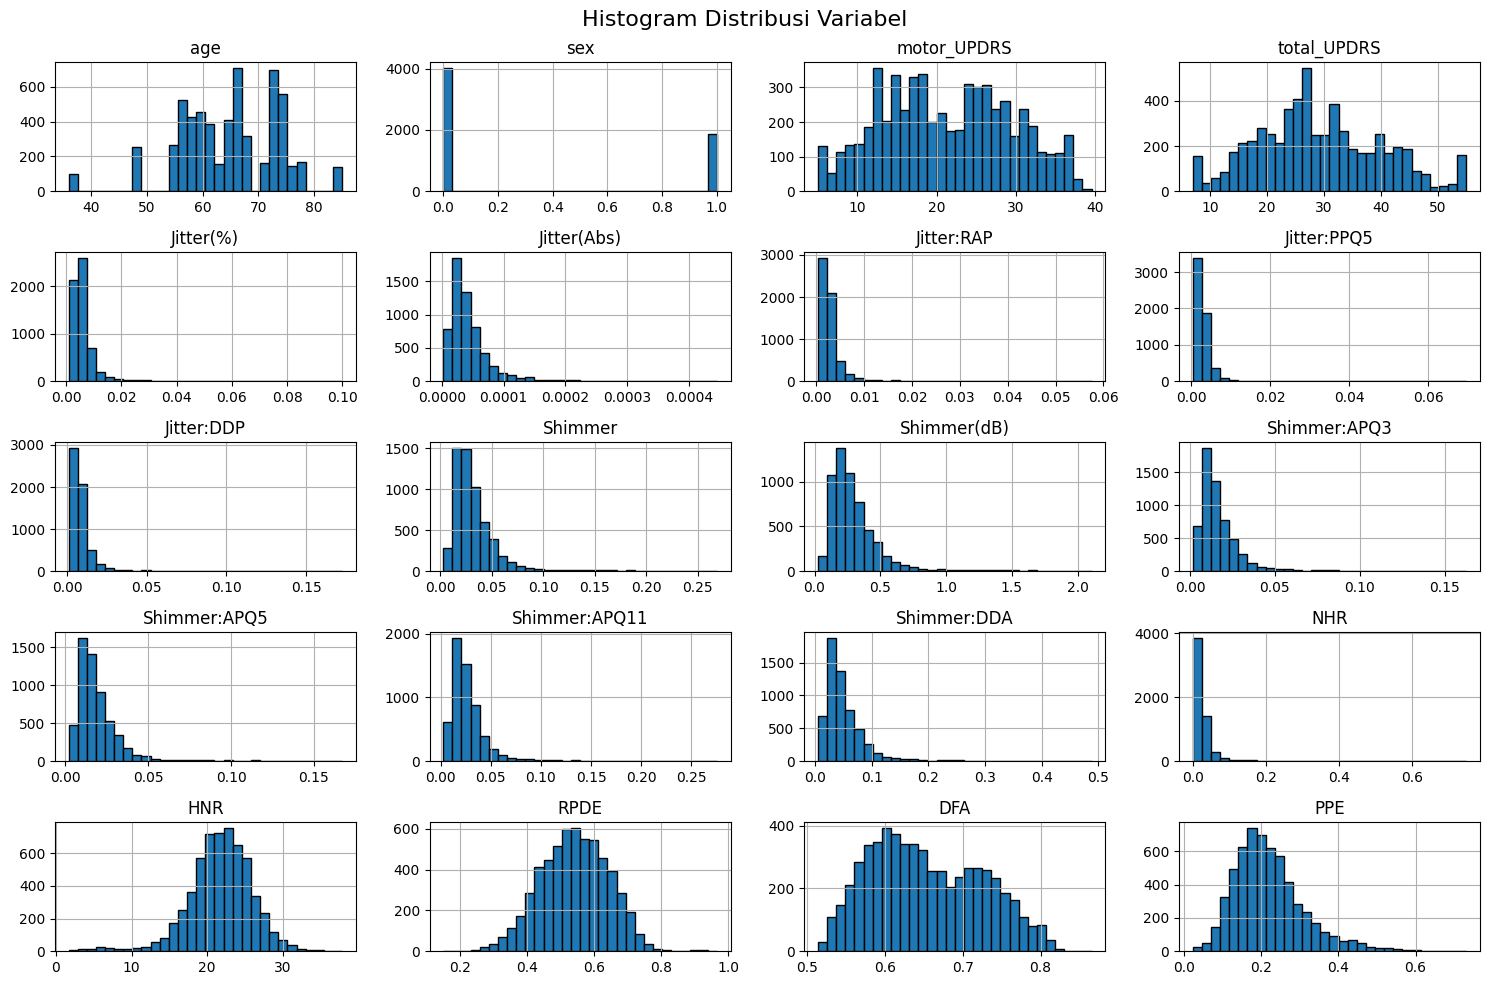

In [ ]:
df.hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Histogram Distribusi Variabel', fontsize=16)
plt.tight_layout()
plt.show()

**Interpretasi Histogram Distribusi Variabel**

* Age & Sex: Mayoritas pasien berusia 50–75 tahun. Variabel jenis kelamin bersifat biner.

* Motor UPDRS & Total UPDRS: Distribusi mendekati normal, menunjukkan variasi tingkat keparahan penyakit.

* Jitter & Shimmer (termasuk variannya): Skewed ke kanan, menunjukkan sebagian besar pasien memiliki nilai rendah, dengan beberapa outlier.

* NHR & HNR: NHR rendah untuk sebagian besar pasien, sedangkan HNR berbentuk lonceng, menunjukkan keseimbangan harmonik dan noise.

* RPDE, DFA, & PPE: Distribusi mendekati normal, menunjukkan pola suara yang cukup konsisten di antara pasien.

## Cek Imbalance Data

sex
0    4008
1    1867
Name: count, dtype: int64
sex
0    0.682213
1    0.317787
Name: proportion, dtype: float64


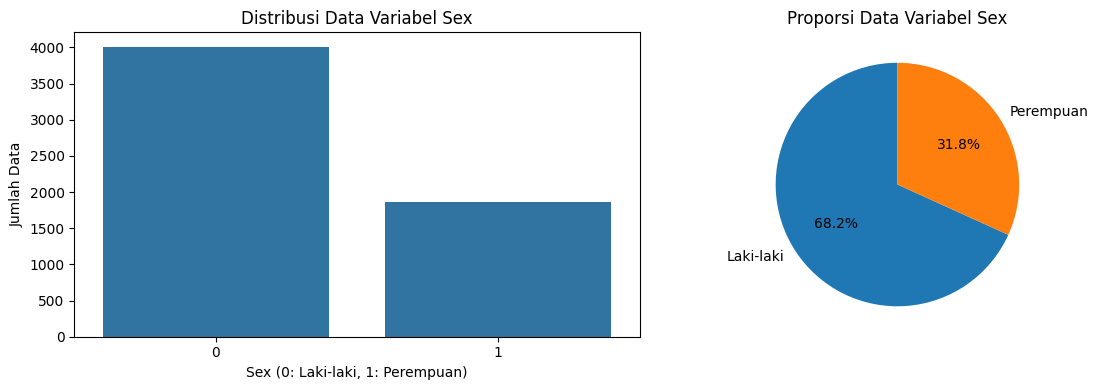

In [ ]:
# Hitung jumlah data untuk setiap kategori pada variabel 'sex'
sex_counts = df['sex'].value_counts()

# Tampilkan jumlah data untuk setiap kategori
print(sex_counts)

# Hitung proporsi setiap kategori
sex_proportions = df['sex'].value_counts(normalize=True)

# Tampilkan proporsi setiap kategori
print(sex_proportions)

# Buat subplot dengan 1 baris dan 2 kolom
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize as needed

# Visualisasi dengan countplot pada subplot pertama (kiri)
sns.countplot(x='sex', data=df, ax=axes[0])
axes[0].set_title('Distribusi Data Variabel Sex')
axes[0].set_xlabel('Sex (0: Laki-laki, 1: Perempuan)')
axes[0].set_ylabel('Jumlah Data')

# Visualisasi dengan pie chart pada subplot kedua (kanan)
axes[1].pie(sex_proportions, labels=['Laki-laki', 'Perempuan'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Proporsi Data Variabel Sex')

# Tampilkan plot
plt.tight_layout()  # Menyesuaikan layout agar tidak tumpang tindih
plt.show()

*   Kategori 0 (laki-laki) memiliki 4008 data dengan proporsi sebesar 68.22%.
*   Kategori 1 (perempuan) memiliki 1867 data dengan proporsi sebesar 31.78%.
perbedaan proporsi antara laki-laki (68.22%) dan perempuan (31.78%) tidak tergolong imbalance yang parah.

Meskipun ada perbedaan, proporsi kategori minoritas (perempuan) masih cukup signifikan (di atas 30%). Dataset dengan proporsi seperti ini masih dianggap cukup seimbang untuk digunakan dalam pemodelan machine learning tanpa perlu penanganan khusus.

## Heatmap Korelasi Antar Variabel

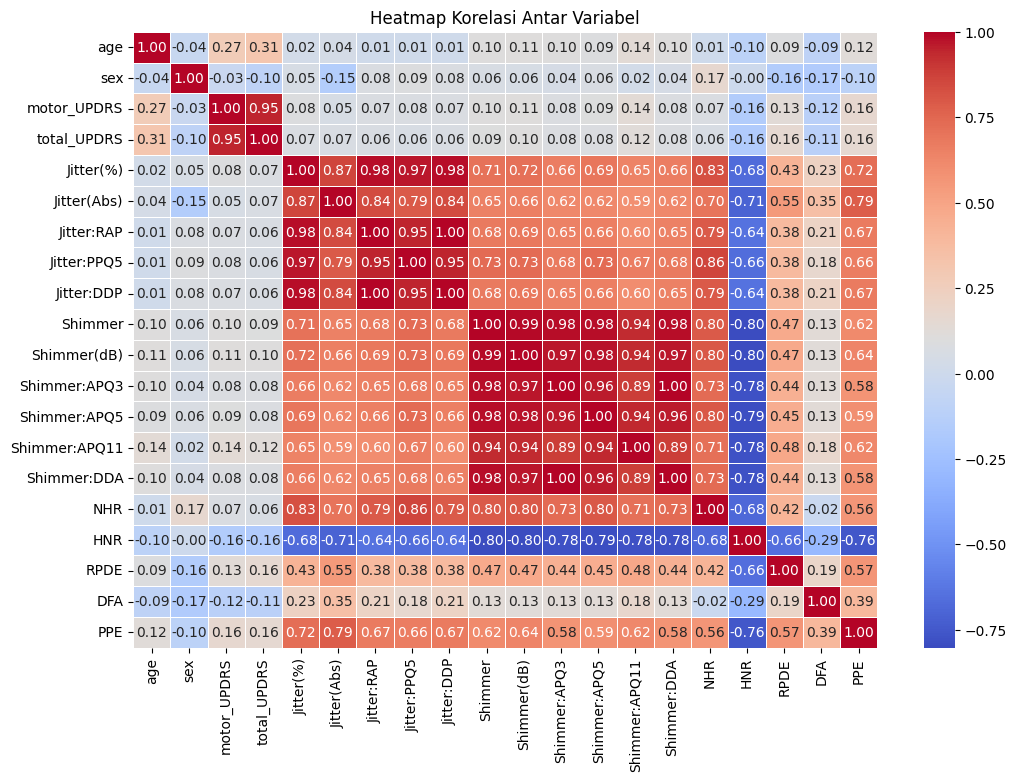

In [ ]:
# Hitung korelasi antar variabel
correlation_matrix = df.corr()

# Plot heatmap korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Tambahkan judul
plt.title("Heatmap Korelasi Antar Variabel")
plt.show()


**Interpretasi Heatmap**

Heatmap ini menunjukkan hubungan antara variabel dalam dataset analisis penyakit Parkinson. Warna merah tua menunjukkan korelasi positif yang kuat (mendekati +1), sedangkan warna biru tua menunjukkan korelasi negatif yang kuat (mendekati -1). Warna putih atau abu-abu menunjukkan korelasi lemah atau hampir nol.

**1. Korelasi Antar Variabel**

* Variabel Jitter dan Shimmer (termasuk variannya) memiliki korelasi sangat tinggi satu sama lain (>0.9), menunjukkan bahwa mereka mengukur karakteristik suara yang serupa.

* HNR memiliki korelasi negatif yang kuat dengan Jitter, Shimmer, dan NHR, menunjukkan bahwa semakin tinggi distorsi suara, semakin rendah nilai HNR.

* RPDE, DFA, dan PPE memiliki korelasi sedang satu sama lain, yang mengindikasikan hubungan antara pola kompleksitas suara dan entropi.

**2. Korelasi dengan Variabel Dependen (Total_UPDRS)**


* Motor UPDRS memiliki korelasi sangat tinggi dengan Total UPDRS (0.95), yang wajar karena Motor UPDRS merupakan bagian dari total skor UPDRS.

* Jitter dan Shimmer memiliki korelasi positif sedang (~0.6-0.12) dengan Total UPDRS, menunjukkan bahwa peningkatan ketidakstabilan suara berhubungan dengan tingkat keparahan penyakit Parkinson.

* HNR menunjukkan korelasi negatif dengan Total UPDRS (-0.16), menandakan bahwa semakin buruk kualitas suara (lebih banyak noise), semakin tinggi tingkat keparahan Parkinson.

* RPDE, DFA, dan PPE memiliki korelasi lemah hingga sedang (~0.3-0.5) dengan Total UPDRS, yang menunjukkan hubungan antara pola perubahan suara dengan tingkat keparahan penyakit.

# **Data Preprocessing**

## One-Hot-Encoding untuk Variabel Kategorik

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# One-Hot-Encoding for Categorical Variable 'sex'
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for regular array
encoded_data = encoder.fit_transform(df[['sex']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['sex']))
df = df.drop('sex', axis=1)  # Remove the original 'sex' column
df = pd.concat([df, encoded_df], axis=1)  # Concatenate the encoded data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            5875 non-null   int64  
 1   motor_UPDRS    5875 non-null   float64
 2   total_UPDRS    5875 non-null   float64
 3   Jitter(%)      5875 non-null   float64
 4   Jitter(Abs)    5875 non-null   float64
 5   Jitter:RAP     5875 non-null   float64
 6   Jitter:PPQ5    5875 non-null   float64
 7   Jitter:DDP     5875 non-null   float64
 8   Shimmer        5875 non-null   float64
 9   Shimmer(dB)    5875 non-null   float64
 10  Shimmer:APQ3   5875 non-null   float64
 11  Shimmer:APQ5   5875 non-null   float64
 12  Shimmer:APQ11  5875 non-null   float64
 13  Shimmer:DDA    5875 non-null   float64
 14  NHR            5875 non-null   float64
 15  HNR            5875 non-null   float64
 16  RPDE           5875 non-null   float64
 17  DFA            5875 non-null   float64
 18  PPE     

## Split Data Training Data Testing

In [ ]:
# Memisahkan Fitur (X) dan Target (Y)
X = df.drop(columns=["motor_UPDRS", "total_UPDRS"])  # Semua fitur kecuali target
Y = df["total_UPDRS"]  # Target : Total UPDRS
# Train-test split 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Dataset dibagi dengan proporsi 80% data training dan 20% data testing menggunakan train_test_split.

## Standarisasi

In [ ]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)
X_train.head()

,age,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex_0,sex_1
3268,-0.545898,-0.112748,0.141961,-0.063881,-0.016430,-0.062775,0.428386,0.377139,0.468909,0.433148,0.592817,0.468658,0.188516,-1.353757,0.082464,1.434638,0.213898,0.678961,-0.678961
4619,-0.660634,-0.387276,-0.024282,-0.444362,-0.306972,-0.444380,-0.886772,-0.933778,-0.866776,-0.779419,-0.797865,-0.866770,-0.227192,-0.038634,0.410805,1.250697,0.338940,0.678961,-0.678961
5681,0.371988,0.250218,-0.113210,0.357005,0.268470,0.358112,0.490975,0.613893,0.664952,0.226612,0.306650,0.664955,0.071312,-0.887897,1.071243,0.084520,0.621374,-1.472838,1.472838
3349,1.289874,-0.046419,0.539587,-0.023476,-0.084129,-0.022370,-0.657930,-0.697024,-0.696669,-0.581968,-0.558968,-0.696409,0.060188,-0.383836,0.620504,-0.991724,0.509511,0.678961,-0.678961
4035,1.519345,-0.263830,-0.436351,-0.329881,-0.095412,-0.328776,0.296557,0.420982,-0.023868,0.321703,1.070610,-0.023864,-0.184047,0.191036,-0.747236,0.043066,0.001174,0.678961,-0.678961


# **Regresi Berganda**

## Regresi Berganda Semua Variabel

In [ ]:
# Tambahkan konstanta (intercept) untuk regresi OLS
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Buat model regresi OLS
model = sm.OLS(Y_train, X_train).fit()

# Ringkasan hasil regresi
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     54.51
Date:                Sat, 29 Mar 2025   Prob (F-statistic):          7.01e-178
Time:                        12:28:31   Log-Likelihood:                -17380.
No. Observations:                4700   AIC:                         3.480e+04
Df Residuals:                    4681   BIC:                         3.492e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            29.0765      0.143    203.693

Dari output tabel Summary Output OLS Regression terdapat beberapa data yang tidak signifikan atau memiliki p-value > 0.05, sehingga hanya ada beberapa variabel yang signifikan saja yang akan dianalisis lebih lanjut pada model **Linear Regression** yaitu variabel **"age", "Jitter(Abs)", "HNR", "DFA", "PPE", "Shimmer:APQ11", "RPDE", "sex_0", dan "sex_1"**.

## Linear Regression Dengan Seluruh Variabel

In [ ]:
# Fungsi evaluasi model (tetap sama)
def evaluate_model(model, X_train, X_test, Y_train, Y_test, model_name):
    model.fit(X_train, Y_train)  # Latih model
    Y_pred = model.predict(X_test)  # Prediksi pada test set

    # Hitung metrik evaluasi
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)

    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "R²": r2}

# Evaluasi model Linear Regression dengan semua variabel (tanpa seleksi fitur)
lin_reg_all = LinearRegression()
linear_results_all = evaluate_model(lin_reg_all, X_train, X_test, Y_train, Y_test, "Linear Regression (All Features)")

# Tampilkan hasil dalam DataFrame
linear_results_all_df = pd.DataFrame([linear_results_all]).set_index("Model")
print(linear_results_all_df)

                                      MAE      RMSE        R²
Model                                                        
Linear Regression (All Features)  8.03362  9.701222  0.150698


**Model Linear Regression**


* MAE: 8.03362
* RMSE: 9.701222
* R²: 0.150698

Hasil evaluasi menunjukkan bahwa model regresi linear memiliki nilai R² sebesar 0.150698, yang berarti hanya 15.06% variasi dalam total_UPDRS dapat dijelaskan oleh fitur yang digunakan. Secara keseluruhan, performa model ini masih rendah karena nilai R² yang kecil menunjukkan bahwa model memiliki kemampuan prediksi yang rendah, dan sebagian besar variasi dalam total_UPDRS dijelaskan oleh faktor lain yang tidak dimasukkan dalam model.

## Regresi Berganda Dengan Variabel Signifikan

In [ ]:
import statsmodels.api as sm

# Pilih hanya variabel signifikan
significant_features = ["age", "Jitter(Abs)", "HNR", "DFA", "PPE", "Shimmer:APQ11", "RPDE", "sex_0", "sex_1"]

# Ambil subset dari X_train dan X_test
X_train_signif = X_train[significant_features]
X_test_signif = X_test[significant_features]

# Tambahkan konstanta (intercept)
X_train_signif = sm.add_constant(X_train_signif)
X_test_signif = sm.add_constant(X_test_signif)

# Buat model regresi OLS
model_signif = sm.OLS(Y_train, X_train_signif).fit()

# Ringkasan hasil regresi
print(model_signif.summary())

                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     111.6
Date:                Sat, 29 Mar 2025   Prob (F-statistic):          2.65e-171
Time:                        12:30:40   Log-Likelihood:                -17418.
No. Observations:                4700   AIC:                         3.485e+04
Df Residuals:                    4691   BIC:                         3.491e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            29.0765      0.144    202.284

**Uji t**

Setelah melakukan regresi berganda dengan menggunakan variabel yang signifikan saja, diperoleh P>|t| pada semua variabel < α (0.05), sehingga semua variabel sudah signifikan.

**Uji F**

Prob (F-statistic) (2.65e-171) < α (0.05), maka model signifikan secara keseluruhan. Sehingga model dapat digunakan untuk prediksi dengan baik.

**Koefisien Determinasi (R-squared)**

R-squared (0.160), artinya variabel-variabel penjelas pada model mampu menjelaskan sekitar 16% keragaman pada variabel Y (total_UPDRS).

## Linear Regression Dengan Variabel yang Signifikan

In [ ]:
# Fungsi evaluasi model
def evaluate_model(model, X_train, X_test, Y_train, Y_test, model_name):
    model.fit(X_train, Y_train)  # Latih model
    Y_pred = model.predict(X_test)  # Prediksi pada test set

    # Hitung metrik evaluasi
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)

    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "R²": r2}

# Gunakan dataset yang sudah dipilih (misalnya dengan variabel signifikan)
lin_reg = LinearRegression()
linear_results = evaluate_model(lin_reg, X_train_signif, X_test_signif, Y_train, Y_test, "Linear Regression")

# Tampilkan hasil dalam DataFrame
linear_results_df = pd.DataFrame([linear_results]).set_index("Model")
print(linear_results_df)

                        MAE      RMSE       R²
Model                                         
Linear Regression  8.086368  9.747764  0.14253


**Model Linear Regression**


* MAE: 8.086368
* RMSE: 9.747764
* R²: 0.14253

Hasil evaluasi menunjukkan bahwa model regresi linear memiliki nilai R² sebesar 0.14253, yang berarti hanya 14.25% variasi dalam total_UPDRS dapat dijelaskan oleh fitur yang digunakan. Secara keseluruhan, performa model ini masih rendah karena nilai R² yang kecil menunjukkan bahwa hubungan antara variabel feature dan target tidak cukup kuat.

In [ ]:
# Mengambil data dari linear_results_all_df dan linear_results_df
data = {
    "Model": ["Linear Regression (All Features)", "Linear Regression (Significant Features)"],
    "MAE": [linear_results_all_df.loc["Linear Regression (All Features)", "MAE"], linear_results_df.loc["Linear Regression", "MAE"]],
    "RMSE": [linear_results_all_df.loc["Linear Regression (All Features)", "RMSE"], linear_results_df.loc["Linear Regression", "RMSE"]],
    "R²": [linear_results_all_df.loc["Linear Regression (All Features)", "R²"], linear_results_df.loc["Linear Regression", "R²"]]
}

# Membuat DataFrame dari data
df_compare = pd.DataFrame(data)

# Membuat HTML table dari DataFrame
html_table = df_compare.to_html(index=False)  # index=False untuk menyembunyikan index

# Menampilkan tabel menggunakan IPython.display.HTML
display(HTML(html_table))

Model,MAE,RMSE,R²
Linear Regression (All Features),8.033620,9.701222,0.150698
Linear Regression (Significant Features),8.086368,9.747764,0.142530


Dari hasil evaluasi, **model dengan semua variabel lebih baik dibandingkan model dengan variabel yang signifikan saja**. Hal ini terlihat dari **MAE dan RMSE yang lebih rendah**, yang menunjukkan bahwa model dengan semua fitur memiliki tingkat kesalahan prediksi yang sedikit lebih kecil. Selain itu, nilai **R² model dengan semua fitur lebih tinggi (15.06% vs 14.25%)**, yang berarti model ini sedikit lebih mampu menjelaskan variabilitas target dibandingkan model dengan fitur signifikan saja.

# **Random Forest**

In [ ]:
# Model Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
Y_pred_rf = rf_model.predict(X_test)

# Evaluasi Model Random Forest
mae_rf = mean_absolute_error(Y_test, Y_pred_rf)
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(Y_test, Y_pred_rf)

# Simpan hasil dalam DataFrame
rf_results_df = pd.DataFrame([{
    "Model": "Random Forest",
    "MAE": mae_rf,
    "RMSE": rmse_rf,
    "R²": r2_rf
}]).set_index("Model")

# Tampilkan hasil
print(rf_results_df)

                   MAE      RMSE        R²
Model                                     
Random Forest  2.14322  2.964426  0.920697


**Model Random Forest**

* MAE = 2.14322
* RMSE = 2.964426
* R² = 0.920697

Berdasarkan hasil evaluasi, model Random Forest menunjukkan performa yang sangat baik dalam memprediksi total_UPDRS. Model ini memiliki kesalahan prediksi yang rendah dan memiliki nilai R² yang tinggi yaitu 0.920697 menunjukkan bahwa model Random Forest mampu menjelaskan 92.06% variabilitas dalam data total_UPDRS. Ini menunjukkan bahwa model sangat akurat dalam memprediksi skor total_UPDRS.

#Feature Importance dengan Random Forest

<ipython-input-23-901da2d651f4>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="viridis")


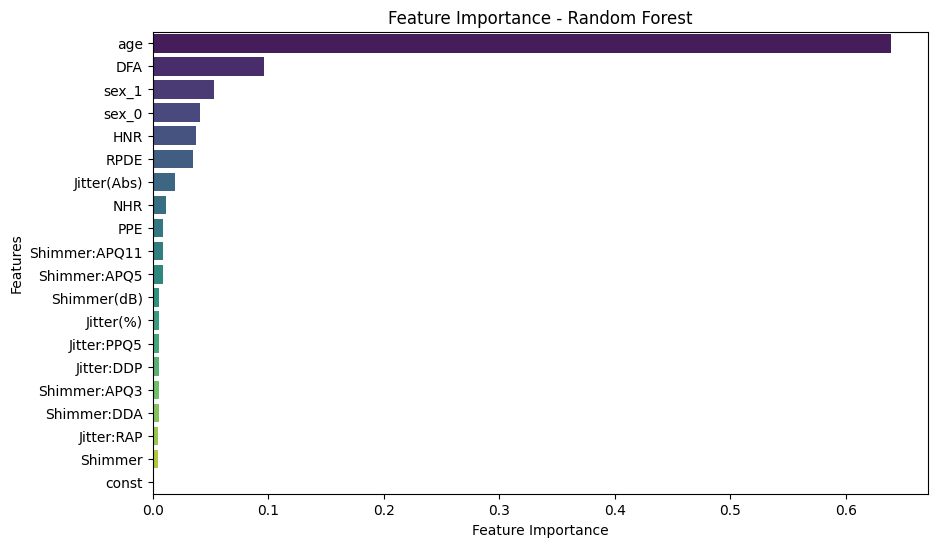

,Feature,Importance
1,age,0.638891
16,DFA,0.095986
19,sex_1,0.053370
18,sex_0,0.040599
14,HNR,0.037771
15,RPDE,0.035049
3,Jitter(Abs),0.019331
13,NHR,0.011364
17,PPE,0.009203
11,Shimmer:APQ11,0.008788


In [ ]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# Tentukan Feature Importance
importances = rf_model.feature_importances_

# Buat DataFrame untuk visualisasi
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Menggunakan X_train agar sesuai dengan fitur yang digunakan
    'Importance': importances
})

# Urutkan berdasarkan importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance - Random Forest")
plt.show()

# Tampilkan DataFrame feature importance
display(feature_importance_df.sort_values(by='Importance', ascending=False))

**1. Interpretasi Feature Importance - Random Forest**

Nilai Feature Importance menunjukkan
kontribusi relatif setiap variabel dalam memprediksi output model. Semakin tinggi nilai Feature Importance, semakin besar pengaruh fitur tersebut dalam proses prediksi.

**2. Analisis Tiap Fitur**

* Fitur paling berpengaruh dalam model ini adalah "age" (0.6388) dan "DFA" (0.095). Ini menunjukkan bahwa fitur ini memiliki kontribusi terbesar dalam menentukan hasil prediksi.

* Fitur dengan pengaruh sedang meliputi "sex_1" (0.053), "sex_0" (0.040), "HNR" (0.037) dan "RPDE" (0.035). Fitur-fitur ini masih berperan dalam model, tetapi pengaruhnya lebih kecil dibandingkan fitur utama.

* Fitur dengan pengaruh rendah meliputi "Jitter(Abs)" dan "NHR" dengan pengaruh pengaruh kurang dari 2% dan fitur lainnya seperti PPE,  Shimmer, Jitter, dan fitur turunan lainnya dengan  nilai importance di bawah 0.01. Fitur-fitur ini memiliki dampak yang sangat kecil terhadap prediksi model.

In [ ]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# Hitung feature importance
importances = rf_model.feature_importances_

# Hitung median dari feature importance
median_importance = np.median(importances)

# Pilih fitur yang memiliki importance lebih dari median
selected_features = X_train.columns[importances > median_importance]
print("Fitur yang dipilih:", selected_features.tolist())

# Transformasi dataset hanya dengan fitur yang dipilih
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

Fitur yang dipilih: ['age', 'Jitter(Abs)', 'Shimmer:APQ11', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'sex_0', 'sex_1']


Berdasarkan hasil seleksi fitur menggunakan **Random Forest Regressor**, variabel dengan **feature importance** tertinggi yang dipilih adalah **age, Jitter(Abs), Shimmer:APQ11, NHR, HNR, RPDE, DFA, PPE, sex_0, sex_1**. Variabel-variabel ini menunjukkan pengaruh signifikan terhadap model.

# **Gradient Boosting, XGBoost, Catboost All Variable**

In [ ]:
# Fungsi Evaluasi Model
def evaluate_model(model, X_train, X_test, Y_train, Y_test, model_name):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)

    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "R²": r2}

# Inisialisasi Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
cat_model = CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)

# Evaluasi Model
gb_results = evaluate_model(gb_model, X_train, X_test, Y_train, Y_test, "Gradient Boosting")
xgb_results = evaluate_model(xgb_model, X_train, X_test, Y_train, Y_test, "XGBoost")
cat_results = evaluate_model(cat_model, X_train, X_test, Y_train, Y_test, "CatBoost")

# Gabungkan hasil dalam DataFrame
results_df = pd.DataFrame([gb_results, xgb_results, cat_results]).set_index("Model")

# Tampilkan hasil
print(results_df)

                        MAE      RMSE        R²
Model                                          
Gradient Boosting  3.980468  5.072025  0.767848
XGBoost            2.500384  3.346484  0.898938
CatBoost           2.713772  3.554604  0.885977


Untuk meningkatkan performa model, dilakukan pemodelan menggunakan algoritma berbasis boosting, yaitu Gradient Boosting, XGBoost, dan CatBoost. Model ini menggunakan seluruh variabel. Hasil evaluasi menunjukkan bahwa:

**Gradient Boosting**
*   MAE = 3.980
*   RMSE = 5.073
*   R² = 0.767

Model Gradient Boosting menunjukkan kesalahan yang jauh lebih besar dibandingkan kedua model lainnya serta memiliki nilai R² sebesar 0.767, yang berarti model hanya dapat menjelaskan 76.7% variabilitas dalam data, jauh lebih rendah dibandingkan XGBoost dan CatBoost.


**XGBoost**

* MAE = 2.500
* RMSE = 3.346
* R² = 0.898

Model XGBoost memiliki performa sangat baik. XGBoost menunjukkan bahwa rata-rata kesalahan absolut model ini paling kecil dibandingkan model lainnya. Dengan nilai RMSE yang rendah menandakan bahwa error kuadratnya juga paling rendah, sehingga lebih andal dalam memprediksi dengan akurasi tinggi serta nilai R² = 0.898 yang berarti model dapat menjelaskan 89.8% variabilitas dalam data, menunjukkan bahwa model ini memiliki kemampuan prediksi yang sangat baik.

**CatBoost**

* MAE = 2.713
* RMSE = 3.554
* R² = 0.885

Model CatBoost juga menunjukkan hasil yang sangat baik, meskipun sedikit lebih rendah dibandingkan XGBoost. CatBoost memiliki nilai MAE dan RMSE yang sedikit lebih besar dibandingkan XGBoost, tetapi masih cukup baik dalam prediksi serta R²= 0.885, menandakan bahwa model ini dapat menjelaskan 88.5% variabilitas data, sedikit lebih rendah dari XGBoost tetapi masih dalam kategori sangat baik.



Dari hasil ini, **XGBoost memiliki performa terbaik**, diikuti oleh **CatBoost**, sementara **Gradient Boosting memiliki performa paling rendah di antara ketiga model**. Hal ini menunjukkan bahwa model berbasis **Boosting (XGBoost)** sangat efektif dalam menangkap pola data dibandingkan dengan regresi linear yang sebelumnya dilakukan.

## Visualisasi Matriks Evaluasi Data Modelling Sebelum Hyperparameter Tuning

<ipython-input-26-f0b7514fc98a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_results_df.index, y=all_results_df[metric], palette="coolwarm")
<ipython-input-26-f0b7514fc98a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_results_df.index, y=all_results_df[metric], palette="coolwarm")
<ipython-input-26-f0b7514fc98a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_results_df.index, y=all_results_df[metric], palette="coolwarm")


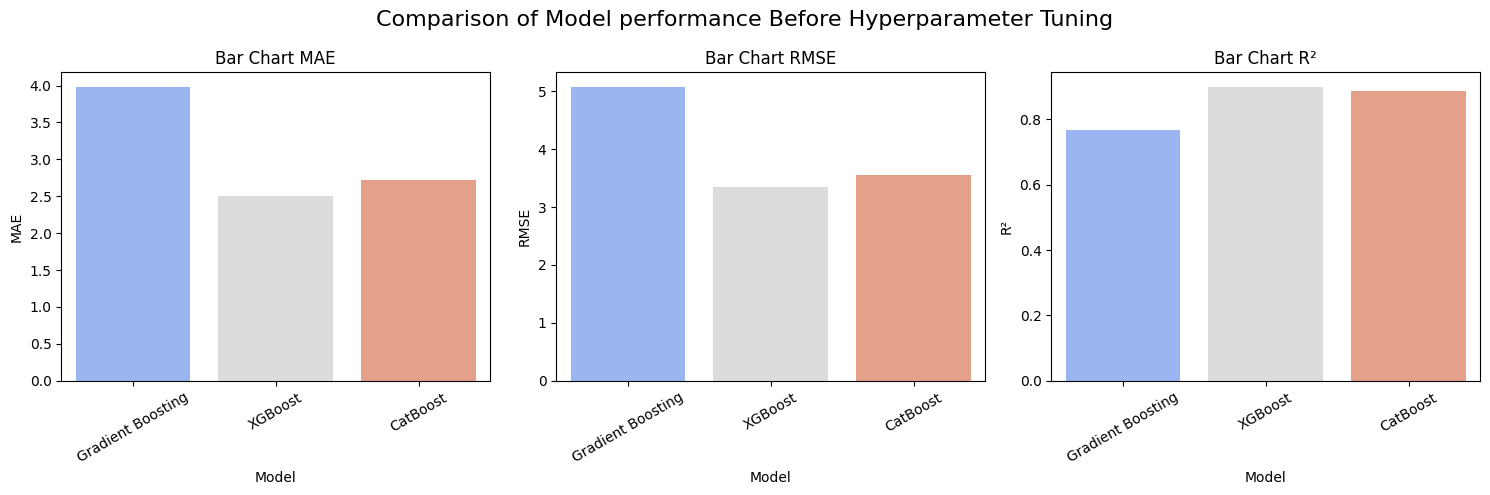

In [ ]:
# Assuming 'linear_results_df' and 'results_df' are DataFrames containing your results
all_results_df = pd.concat([results_df]) # Combine results

# Atur ukuran plot
plt.figure(figsize=(15, 5))

# Judul keseluruhan
plt.suptitle("Comparison of Model performance Before Hyperparameter Tuning", fontsize=16)

# Loop untuk membuat bar plot setiap metrik
metrics = ["MAE", "RMSE", "R²"]
titles = ["Bar Chart MAE", "Bar Chart RMSE", "Bar Chart R²"]

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.barplot(x=all_results_df.index, y=all_results_df[metric], palette="coolwarm")
    plt.xticks(rotation=30)
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.title(titles[i])

# Tampilkan plot
plt.tight_layout()
plt.show()

Berdasarkan grafik sebelum hyperparameter tuning, model XGBoost memiliki performa terbaik dengan nilai MAE dan RMSE paling rendah serta R² tertinggi dibandingkan Gradient Boosting dan CatBoost. Sebaliknya, Gradient Boosting menunjukkan performa paling buruk dengan kesalahan yang lebih tinggi dan R² yang lebih rendah. CatBoost berada di tengah dengan performa yang lebih baik dari Gradient Boosting.

# **Hyperparameter Tuning dengan GridSearchCV**

**Hyperparameter Tuning dengan GridSearchCV**

Hyperparameter tuning adalah proses mengoptimalkan parameter dalam model machine learning untuk mencapai performa terbaik. Salah satu metode yang digunakan adalah GridSearchCV, yang bekerja dengan menguji berbagai kombinasi parameter yang telah ditentukan dalam grid dan mengevaluasi performanya menggunakan cross-validation (CV).

Setelah dilakukan hyperparameter tuning dengan GridSearchCV, hasil yang diperoleh menunjukkan bahwa tidak semua model mengalami peningkatan performa secara signifikan. Beberapa model menunjukkan perbaikan akurasi atau pengurangan error, sementara yang lain tetap memiliki hasil yang serupa dengan sebelum dilakukan tuning.

## Gradient Boosting, XGBoost, CatBoost

In [ ]:
# Grid Search Parameter Grids
param_grids = {
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "CatBoost": {
        "iterations": [100, 200],
        "learning_rate": [0.05, 0.1],
        "depth": [4, 6],
        "l2_leaf_reg": [1, 3]
    }
}

# Model Initialization
models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

# Hyperparameter Tuning with GridSearchCV
best_models = {}
results = []

for name, model in models.items():
    print(f"Tuning {name}...")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring="neg_mean_absolute_error",
        cv=3,  # Reduced CV for faster computation
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, Y_train)

    # Store Best Model
    best_models[name] = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make Predictions
    Y_pred = best_models[name].predict(X_test)

    # Evaluate Model
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)

    # Store Results
    results.append({
        "Model": name,
        "Best Params": best_params,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# Convert Results to DataFrame
results_df_tuned = pd.DataFrame(results).set_index("Model")

# Display Results
print(results_df_tuned)

Tuning Gradient Boosting...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Tuning XGBoost...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Tuning CatBoost...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
                                                         Best Params  \
Model                                                                  
Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 5, 'min_sa...   
XGBoost            {'colsample_bytree': 1.0, 'learning_rate': 0.1...   
CatBoost           {'depth': 6, 'iterations': 200, 'l2_leaf_reg':...   

                        MAE      RMSE        R²  
Model                                            
Gradient Boosting  2.546769  3.390885  0.896239  
XGBoost            2.435143  3.249111  0.904734  
CatBoost           2.741545  3.577068  0.884531  


In [ ]:
# Mengambil data dari results_df dan results_df_tuned
models = ['Gradient Boosting', 'XGBoost', 'CatBoost']
data = []
for model in models:
    mae_sebelum = results_df.loc[model, 'MAE']
    rmse_sebelum = results_df.loc[model, 'RMSE']
    r2_sebelum = results_df.loc[model, 'R²']
    mae_sesudah = results_df_tuned.loc[model, 'MAE']
    rmse_sesudah = results_df_tuned.loc[model, 'RMSE']
    r2_sesudah = results_df_tuned.loc[model, 'R²']
    data.append([model, mae_sebelum, mae_sesudah, rmse_sebelum, rmse_sesudah, r2_sebelum, r2_sesudah])

# Membuat HTML table
table_html = """
<table>
  <tr>
    <th>Model</th>
    <th>MAE (Sebelum)</th>
    <th>MAE (Sesudah)</th>
    <th>RMSE (Sebelum)</th>
    <th>RMSE (Sesudah)</th>
    <th>R² (Sebelum)</th>
    <th>R² (Sesudah)</th>
  </tr>
  {}
</table>
""".format(
    "".join(
        "<tr><td>{}</td><td>{:.3f}</td><td>{:.3f}</td><td>{:.3f}</td><td>{:.3f}</td><td>{:.3f}</td><td>{:.3f}</td></tr>".format(*row)
        for row in data
    )
)

# Menampilkan tabel
display(HTML(table_html))

Model,MAE (Sebelum),MAE (Sesudah),RMSE (Sebelum),RMSE (Sesudah),R² (Sebelum),R² (Sesudah)
Gradient Boosting,3.980,2.547,5.072,3.391,0.768,0.896
XGBoost,2.500,2.435,3.346,3.249,0.899,0.905
CatBoost,2.714,2.742,3.555,3.577,0.886,0.885


**Kesimpulan Per Model**  
1. **Gradient Boosting** menunjukkan peningkatan performa yang paling signifikan. Model ini mengalami penurunan MAE dari 3.980 menjadi 2.547, serta RMSE dari 5.072 menjadi 3.391, yang menunjukkan bahwa error prediksi berkurang secara drastis. Selain itu, R² meningkat dari 0.768 menjadi 0.896, menandakan bahwa model lebih mampu menjelaskan variasi dalam data setelah tuning.  
2. **XGBoost** mengalami sedikit peningkatan performa setelah tuning. MAE menurun sedikit dari 2.500 menjadi 2.435, begitu pula dengan RMSE yang turun dari 3.346 menjadi 3.249. Nilai R² naik tipis dari 0.899 menjadi 0.905, dan tetap berada pada performa yang tinggi. Hal ini menunjukkan bahwa tuning yang dilakukan tidak memberikan dampak yang besar terhadap performa model, tetapi tetap lebih baik dari sebelumnya.  
3. **CatBoost** mengalami sedikit penurunan performa setelah tuning. MAE meningkat dari 2.714 menjadi 2.742, RMSE naik dari 3.555 menjadi 3.577, dan R² turun dari 0.886 menjadi 0.885. Meskipun masih memiliki performa yang cukup baik, tuning yang dilakukan mungkin belum optimal dan perlu dievaluasi lebih lanjut.  


Hyperparameter tuning berhasil meningkatkan performa model secara keseluruhan, terutama pada **Gradient Boosting**, yang menunjukkan peningkatan akurasi yang signifikan. **XGBoost tetap menjadi model terbaik dengan performa yang sangat tinggi**, sementara **CatBoost menunjukkan sedikit penurunan permorma**. XGBoost menjadi pilihan utama dengan keseimbangan antara akurasi dan kestabilan model.

## Visualisasi Matriks Evaluasi Data Modelling Setelah Hyperparameter Tuning

<ipython-input-30-b2799999ee90>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_results_df.index, y=all_results_df[metric], palette="coolwarm")
<ipython-input-30-b2799999ee90>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_results_df.index, y=all_results_df[metric], palette="coolwarm")
<ipython-input-30-b2799999ee90>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_results_df.index, y=all_results_df[metric], palette="coolwarm")


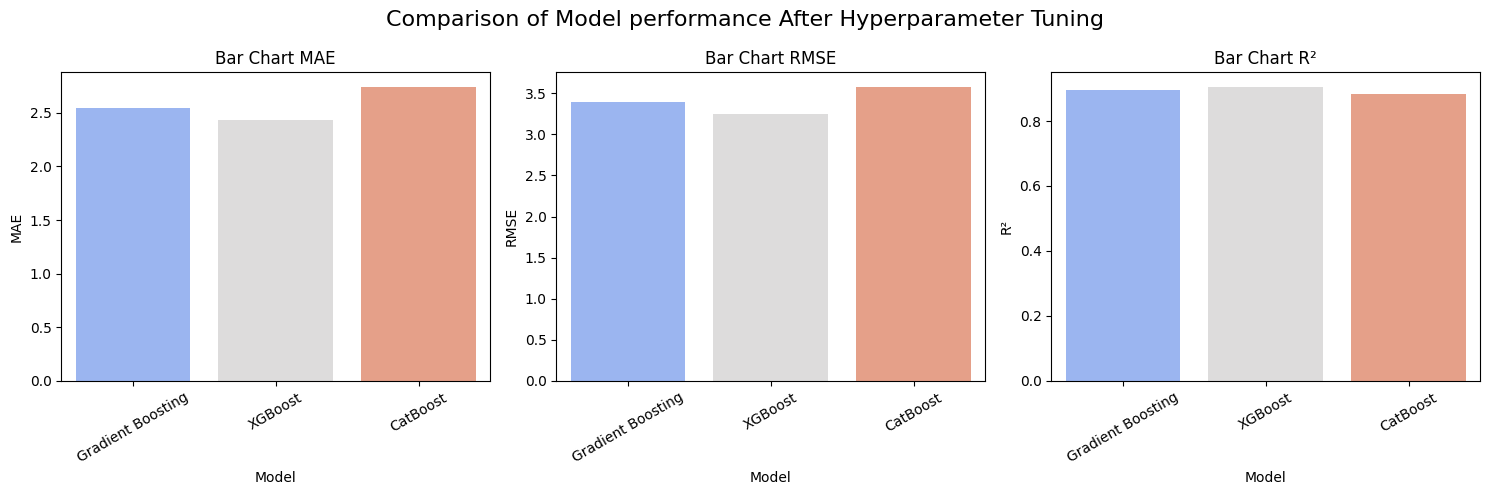

In [ ]:
# Gabungkan hasil
all_results_df = pd.concat([results_df_tuned])

# Atur ukuran plot
plt.figure(figsize=(15, 5))

# Judul keseluruhan
plt.suptitle("Comparison of Model performance After Hyperparameter Tuning", fontsize=16)

# Loop untuk membuat bar plot setiap metrik
metrics = ["MAE", "RMSE", "R²"]
titles = ["Bar Chart MAE", "Bar Chart RMSE", "Bar Chart R²"]

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.barplot(x=all_results_df.index, y=all_results_df[metric], palette="coolwarm")
    plt.xticks(rotation=30)
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.title(titles[i])

# Tampilkan plot
plt.tight_layout()  # Menyesuaikan layout agar tidak tumpang tindih
plt.show()

Setelah dilakukan hyperparameter tuning, Gradient Boosting mengalami peningkatan performa yang signifikan, dengan MAE dan RMSE yang jauh lebih rendah serta peningkatan nilai R². Model ini hampir menyamai performa XGBoost, yang tetap mempertahankan posisinya sebagai model terbaik dengan sedikit peningkatan performa model. Sebaliknya, CatBoost mengalami sedikit penurunan performa setelah tuning, menjadikannya model dengan performa paling rendah dibandingkan yang lain.

# **Pemilihan Model Terbaik**

**Performa
Sebelum Hyperparameter Tuning**

Model terbaik berdasarkan hasil MAE, RMSE dan R² yaitu **XGBoost** dengan MAE = 2.500, RMSE = 3.346, dan R² = 0.899

---

**Performa Setelah Hyperparameter Tuning GridSearch CV**

Setelah dilakukan hyperparameter tuning, didapatkan model terbaik berdasarkan hasil MAE, RMSE dan R² tetap yaitu **XGBoost** denganMAE = 2.435, RMSE = 3.249, dan R² = 0.905 yang mana hasil ini tidak jauh berbeda dengan sebelum hyperparameter, tetapi tetap lebih baik daripada sebelum dilakukan hyperparameter tuning.

---
**Kesimpulan Model Terbaik**

Berdasarkan hasil evaluasi sebelum dan sesudah hyperparameter tuning, model **XGBoost** memberikan performa terbaik dalam memprediksi total_UPDRS. Hal ini ditunjukkan oleh nilai MAE, RMSE, dan R² yang lebih baik dibandingkan model lainnya. Hyperparameter tuning pada XGBoost meningkatkan performa model, terlihat dari penurunan MAE & RMSE serta sedikit peningkatan pada R². Model **XGBoost** menunjukkan performa terbaik dalam memprediksi total_UPDRS, dengan tingkat akurasi mencapai **90.5%** pada dataset Parkinson Telemonitoring.

# **Pemodelan XGBoost Menggunakan Variabel Terpilih Pada Feature Importance**

In [ ]:
# Inisialisasi model XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

# Melatih model dengan X_train_selected dan Y_train
xgb_model.fit(X_train_selected, Y_train)

# Melakukan prediksi dengan X_test_selected
Y_pred = xgb_model.predict(X_test_selected)

# Evaluasi model
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

# Membuat DataFrame untuk hasil evaluasi
results_df_selected = pd.DataFrame({
    "Model": ["XGBoost with Selected Features"],
    "MAE": [mae],
    "RMSE": [rmse],
    "R²": [r2]
}).set_index("Model")

# Menampilkan DataFrame
results_df_selected

,MAE,RMSE,R²
Model,,,
XGBoost with Selected Features,2.452639,3.330015,0.899931


**Interpretasi XGBoost Before Tuning:**

* MAE: 2.4526
* RMSE: 3.3300
* R²: 0.8999

Kesimpulan:
Model XGBoost sebelum tuning sudah memiliki performa yang baik dengan R² = 0.8999, yang berarti mampu menjelaskan 89.99% variasi dalam total_UPDRS. Nilai MAE dan RMSE yang relatif rendah menunjukkan bahwa prediksi cukup akurat.

## Hyperparameter Tuning GridSearchCV Model XGBoost (Variabel terpilih Pada Feature Importance)

In [ ]:
# Menentukan parameter grid untuk tuning
param_grid = {
       "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
}

# Inisialisasi model XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',  # Menggunakan R² sebagai metrik evaluasi
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Melakukan pencarian hyperparameter terbaik
grid_search.fit(X_train_selected, Y_train)

# Menampilkan hyperparameter terbaik
print("Best Parameters:", grid_search.best_params_)

# Menggunakan model terbaik untuk prediksi
best_xgb_model = grid_search.best_estimator_
Y_pred_best = best_xgb_model.predict(X_test_selected)

# Evaluasi model terbaik
mae_best = mean_absolute_error(Y_test, Y_pred_best)
mse_best = mean_squared_error(Y_test, Y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(Y_test, Y_pred_best)

# Membuat DataFrame untuk hasil evaluasi
results_df_selected_tuned = pd.DataFrame({
    "Model": ["XGBoost with Best Hyperparameters"],
    "MAE": [mae_best],
    "RMSE": [rmse_best],
    "R²": [r2_best]
}).set_index("Model")

# Menampilkan DataFrame
results_df_selected_tuned

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


,MAE,RMSE,R²
Model,,,
XGBoost with Best Hyperparameters,2.423139,3.229186,0.905899


In [ ]:
# Assuming results_df_selected and results_df_selected_tuned are defined as in the provided code.

# Create a comparison DataFrame
comparison_df_selected = pd.DataFrame({
    'Model': ['XGBoost Selected Features (Before Tuning)', 'XGBoost Selected Features (After Tuning)'],
    'MAE': [results_df_selected.loc['XGBoost with Selected Features', 'MAE'], results_df_selected_tuned.loc['XGBoost with Best Hyperparameters', 'MAE']],
    'RMSE': [results_df_selected.loc['XGBoost with Selected Features', 'RMSE'], results_df_selected_tuned.loc['XGBoost with Best Hyperparameters', 'RMSE']],
    'R²': [results_df_selected.loc['XGBoost with Selected Features', 'R²'], results_df_selected_tuned.loc['XGBoost with Best Hyperparameters', 'R²']]
}).set_index('Model')


# Display the comparison
comparison_df_selected

,MAE,RMSE,R²
Model,,,
XGBoost Selected Features (Before Tuning),2.452639,3.330015,0.899931
XGBoost Selected Features (After Tuning),2.423139,3.229186,0.905899


**XGBoost After Tuning:**

* MAE: 2.4231
* RMSE: 3.2292
* R²: 0.9059

Kesimpulan:
Setelah tuning, performa model sedikit meningkat dengan R² naik menjadi 90.59%. Penurunan MAE dan RMSE menunjukkan bahwa prediksi lebih akurat dibanding sebelum tuning. Meskipun peningkatannya tidak drastis, tuning tetap memberikan manfaat dalam mengoptimalkan model.

In [ ]:
# Assuming you have the following variables:
mae_all_features_tuned = results_df_tuned.loc["XGBoost", "MAE"] # Mengambil data setelah tuning
rmse_all_features_tuned = results_df_tuned.loc["XGBoost", "RMSE"] # Mengambil data setelah tuning
r2_all_features_tuned = results_df_tuned.loc["XGBoost", "R²"] # Mengambil data setelah tuning

# The index name is "XGBoost with Best Hyperparameters" not "XGBoost with Selected Features"
mae_selected_features = results_df_selected_tuned.loc["XGBoost with Best Hyperparameters", "MAE"]
rmse_selected_features = results_df_selected_tuned.loc["XGBoost with Best Hyperparameters", "RMSE"]
r2_selected_features = results_df_selected_tuned.loc["XGBoost with Best Hyperparameters", "R²"]

# Create the HTML table
html_table = f"""
<table>
  <thead>
    <tr>
      <th>Model</th>
      <th>MAE</th>
      <th>RMSE</th>
      <th>R²</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>XGBoost (All Features)</td>
      <td>{mae_all_features_tuned:.3f}</td>
      <td>{rmse_all_features_tuned:.3f}</td>
      <td>{r2_all_features_tuned:.3f}</td>
    </tr>
    <tr>
      <td>XGBoost (Selected Features)</td>
      <td>{mae_selected_features:.3f}</td>
      <td>{rmse_selected_features:.3f}</td>
      <td>{r2_selected_features:.3f}</td>
    </tr>
  </tbody>
</table>
"""

# Display the table using IPython.display.HTML
from IPython.display import HTML
display(HTML(html_table))

Model,MAE,RMSE,R²
XGBoost (All Features),2.435,3.249,0.905
XGBoost (Selected Features),2.423,3.229,0.906


**Interpretasi Performa XGBoost dengan Fitur Terpilih (Selected Features)**

Pada model XGBoost dengan fitur terpilih, hasil evaluasi menunjukkan:

* **MAE (Mean Absolute Error) = 2.423**.
Rata-rata kesalahan absolut antara prediksi dan nilai aktual turun menjadi 2.423, yang berarti model dengan fitur terpilih memiliki kesalahan yang lebih kecil dibandingkan model dengan semua fitur (2.435).

* **RMSE (Root Mean Squared Error) = 3.229**. RMSE juga mengalami penurunan menjadi 3.229, yang menunjukkan bahwa model dengan fitur terpilih mampu mengurangi dampak kesalahan besar dalam prediksi dibandingkan model sebelumnya (RMSE = 3.249).

* **R² (Koefisien Determinasi) = 0.906**. Nilai R² meningkat menjadi 0.906, yang berarti model dengan fitur terpilih mampu menjelaskan 90.6% variabilitas dalam data target, lebih tinggi dibandingkan model sebelumnya (90.5%).

**Kesimpulan**

* Model XGBoost dengan fitur terpilih lebih optimal dibandingkan dengan model menggunakan semua fitur. Oleh karena itu dapat disimpulkan bahwa variabel X terpilih **(age, Jitter(Abs), Shimmer:APQ11, NHR, HNR, RPDE, DFA, PPE, sex_0, sex_1)** adalah variabel yang memiliki pengaruh signifikan terhadap variabel Y **(Total_UPDRS)**.

* Seleksi fitur membantu meningkatkan akurasi model, dengan mengurangi noise atau fitur yang tidak relevan.

* Hasil ini menunjukkan bahwa tidak semua fitur dalam dataset memberikan kontribusi signifikan, dan memilih fitur yang paling berpengaruh dapat meningkatkan performa model.